# Bibliotecas

In [1]:
!pip uninstall keras -y

Found existing installation: keras 3.1.1
Uninstalling keras-3.1.1:
  Successfully uninstalled keras-3.1.1


In [2]:
!pip install tensorflow==2.13.0
!pip install keras==2.13.0
#pip install keras==3.3.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 75.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 66.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 26.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting un

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import os

from pathlib import Path
import pandas as pd

import pickle

from sklearn.model_selection import train_test_split
import tensorflow as tf

import keras

#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras import Model
from keras.optimizers import Adam

import time

In [5]:
print(tf.__version__)

2.15.0


In [6]:
print(keras.__version__)

3.1.1


# Pré-processamento

In [7]:
train_folder="/kaggle/input/balanced-garbage-classification/train"
val_folder="/kaggle/input/balanced-garbage-classification/val"
test_folder="/kaggle/input/balanced-garbage-classification/test"

In [8]:
train_generator = ImageDataGenerator (preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                      #validation_split=0.2 # o subset ja esta separado
                                      )

test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [9]:
train_images = train_generator.flow_from_directory(
    directory=train_folder,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    #subset='training' # o subset de treino ja esta separado
)

val_images = train_generator.flow_from_directory(
    directory=val_folder,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    #subset='validation'
)

test_images = test_generator.flow_from_directory(
    directory=test_folder,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 5036 images belonging to 12 classes.
Found 1085 images belonging to 12 classes.
Found 1077 images belonging to 12 classes.


# Modelo: ResNet50

In [10]:
pretrained_model=tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    #classes=12,
    classifier_activation="softmax",
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [11]:
pretrained_model.trainable = False

In [12]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

checkpoint_path = "/kaggle/working/keras2_resnet50.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True, # default eh False
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [13]:
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 3,
                               restore_best_weights = True)

In [14]:
inputs=pretrained_model.inputs
x = tf.keras.layers.Dense(256,activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(12, activation='softmax')(x)

In [15]:
from keras import Model

model=Model(inputs,outputs)

In [16]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.5)

In [17]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

# Treinamento

In [18]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/50
  1/315 ━━━━━━━━━━━━━━━━━━━━ 1:33:50 18s/step - accuracy: 0.0000e+00 - loss: 3.5611

I0000 00:00:1718740764.880278     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718740764.933983     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


314/315 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.4106 - loss: 1.8622

W0000 00:00:1718740825.578640     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 95s 244ms/step - accuracy: 0.4119 - loss: 1.8583 - val_accuracy: 0.8654 - val_loss: 0.4615
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - accuracy: 0.8525 - loss: 0.4927 - val_accuracy: 0.9005 - val_loss: 0.3007
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - accuracy: 0.9092 - loss: 0.3082 - val_accuracy: 0.9152 - val_loss: 0.2681
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.9226 - loss: 0.2492 - val_accuracy: 0.9198 - val_loss: 0.2346
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.9516 - loss: 0.1752 - val_accuracy: 0.9309 - val_loss: 0.2185
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.9560 - loss: 0.1378 - val_accuracy: 0.9309 - val_loss: 0.2010
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.9681 - loss: 0.1141 - val_accuracy: 0.9336 - val_loss: 0.1991
Epoch 8/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step - accuracy: 0.9708 - loss: 0.0922 - val_accura

In [19]:
model.save("/kaggle/working/keras2_resnet50_pesos.h5")

# Teste

In [20]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.21251
Test Accuracy: 93.50%


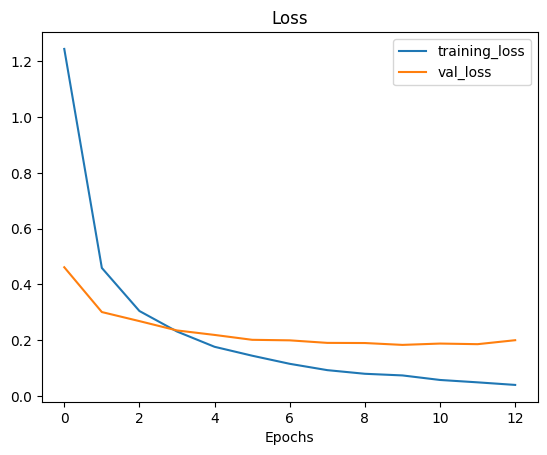

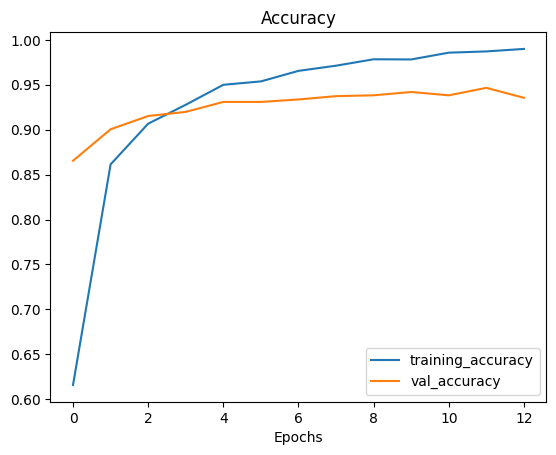

In [21]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

# Tempo de inferência

In [22]:
import time

start=time.time()

pred_og=model.predict(test_images)

end=time.time()

 6/68 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

W0000 00:00:1718741189.636748     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step


In [23]:
pred=np.argmax(pred_og,axis=1)

In [24]:
media=(end-start)/7417
print("Tempo de inferência médio: "+str(media)+" segundos")

Tempo de inferência médio: 0.0016026811264138892 segundos


# Dataframe do conjunto de testes

In [25]:
#dataset="/kaggle/input/garbage-classification-u-diretorios/test"
dataset="/kaggle/input/balanced-garbage-classification/test"
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.PNG')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
#filepaths = pd.Series(filepaths, name='Filepath').astype(np.array)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
test_df = pd.concat([filepaths, labels], axis=1)
test_df=test_df.sort_values(by='Label')

In [26]:
test_df

,Filepath,Label
532,/kaggle/input/balanced-garbage-classification/...,battery
507,/kaggle/input/balanced-garbage-classification/...,battery
506,/kaggle/input/balanced-garbage-classification/...,battery
505,/kaggle/input/balanced-garbage-classification/...,battery
504,/kaggle/input/balanced-garbage-classification/...,battery
...,...,...
146,/kaggle/input/balanced-garbage-classification/...,white_glass
147,/kaggle/input/balanced-garbage-classification/...,white_glass
148,/kaggle/input/balanced-garbage-classification/...,white_glass
151,/kaggle/input/balanced-garbage-classification/...,white_glass


In [27]:
# one hot encoding
from sklearn.preprocessing import LabelBinarizer

y_true = LabelBinarizer().fit_transform(test_df.Label)
y_true=np.argmax(y_true,axis=1)

In [28]:
pred=np.argmax(pred_og,axis=1)

# Precision, Recall, F1-score

In [1]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_true, pred))

NameError: name 'y_true' is not defined

# Matriz de confusão

In [30]:
CM = confusion_matrix(y_true, pred)

class_names = os.listdir(dataset)

CM_df = pd.DataFrame(CM, index=class_names, columns=class_names)
total_true = np.sum(CM, axis=1)
CM_percent = (CM / total_true[:, None]) * 100
CM_percent_df = pd.DataFrame(CM_percent, index=class_names, columns=class_names)

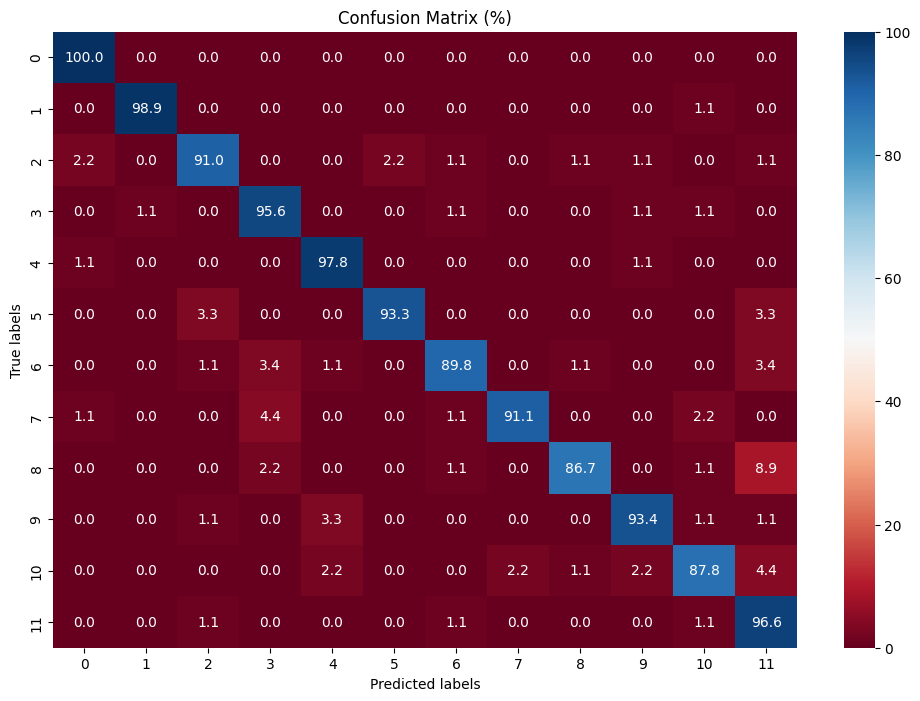

In [31]:
plt.figure(figsize=(12, 8))
sns.heatmap(CM_percent, annot=True, fmt='.1f', cmap='RdBu', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (%)')
plt.show()

# TensorFlow Lite

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [33]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = val_images #representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8 

In [ ]:
tflite_model = converter.convert()

Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x79c98c43c1f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
